# Exercise 6: Time Series Prediction (31 Points)

In this exercise, you will have a look on a different type of prediction problem: **time series prediction**.
You will implement and evaluate the commonly used time series predictor SARIMA on the dataset of positive corona tests.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- christoph.staudt@uni-jena.de

### Submission

- Deadline of submission:
        02.06.2022 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=28746)

# Dataset

The global COVID-19 pandemic has led to the creation of enormous datasets, that let us evaluate the trend of the pandemic. 

Here we will use the daily updated [preprocessed dataset](https://github.com/jgehrcke/covid-19-germany-gae) stored as `cases-rki-by-state.csv`.

Each row in this dataset is a daily report from a german county on reported cases of COVID-19. It contains the following attributes:

- `time_iso8601`: Datetime in iso8601 formatting
- `DE-xx`: Where xx is one of the 16 German federal states, which contains the total number of cases until `time_iso8601`
- `sum_cases` cumulative sum of all cases in Germany until `time_iso8601`

In this task, we are only interested in the development of positive cases over time.

As a sanity check, you can compare your solution with the official 
[Corona Dashboard](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4) of the RKI (here a 
[faster version](https://covid-karte.de/)), but you should expect a small mismatch in the data. 

### Task 1 (5 Points)
Load and prepare the dataset into a timeline that hold the number of reported positive cases over time. So on the x-axis should be the days since the first reported case in the dataset (i.e. range from 0 to ~800), while the y-axis shows the reported new cases on that day. Since the first day is a bit skewed and the last days always need a while to be accurate (delay in reporting), you should remove the first and last 14 entries.

Hints: 
    - You can use pandas to load the csv and [transform the dates to datetime objects](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
    - Pandas can also turn the cummulative sum into [differences](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) to get the new cases for each day.

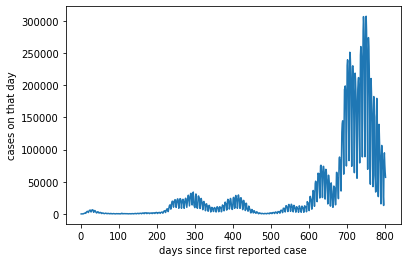

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# TODO: load data
df = pd.read_csv("cases-rki-by-state.csv")

# TODO: process data
dates = pd.to_datetime(df['time_iso8601'])
# i could have used df[1:-14].index, but idk if we could assume that we got data for every single day
x_t = ((dates - dates[0]).dt.days)[1:-14].to_numpy()
y_t = df['sum_cases'].diff()[1:-14].to_numpy()

# TODO: plot curve
plt.plot(x_t, y_t)
plt.xlabel("days since first reported case")
plt.ylabel("cases on that day")
plt.show()

# y_t[i] are the number of cases on the i-th day
assert y_t[0] == 85
assert y_t[10] == 1452
assert y_t[800] == 65032

# Time series prediction

The problem of predicting the next value in a time series is fundamentaly different from the prediction problems we have seen so far, as the points in a time series do naturally depend on each other. 

First, we want to introduce a baseline predictor, against which we can compare our later predictors.

### Task 2 (1 Point)

An extremely simple predictor is the **naive predictor**, that predicts the last value of a time series as the next value. Implement and test this predictor.

In [35]:
import numpy as np

def naive(time_series):
    # TODO: return prediction of naive predictor
    return time_series[-1]

# TODO: test predictor

assert(naive(np.array([1,2,3])) == 3)

Next, we want to introduce a quality measure that evaluates the quality of a predictor.

Let 
- $y_1,\dots,y_n$ be a time series of lenght $n$
- $m<n$ be an index of the time series
- $p_k: \mathbb{R}^k\rightarrow \mathbb{R}$ be a predictor, that predicts a next value for a given time series of length $k$
- $d(y_i,\hat{y}_i)$ be a distance measure between predicted and actual value

**Walk forward validation** for a predictor $p_k$ is defined as 

$$
\cfrac{1}{n-m}\sum\limits_{i=0}^{n-m-1}d\left(y_{m+i+1}, p_{m+i}\left(\left[y_j\right]_{j=1,\dots,m+i}\right)\right)
$$

in other words, starting with the first $m$ steps of the time series, we determine the error of the predicted next value. We then walk one step forward in the time series (first $m+1$ steps) and repeat the process until we predicted the last value of the time series. The average prediction error is then reported as walk forward validation.

### Task 3 (4 Points)

Implement the `wfv` function, that takes as input:
- `predictor`: A function, that takes as input a time series and outputs the predicted next value
- `time series`: A time series
- `s_perc`: percentage of the time series to start the walk forward validation with
- `plot` : optional keyword, that lets you plot the predicted values vs. the actual values.

Use $d(y_i,\hat{y}_i) = | y_i - \hat{y}_i|$ as distance measure. This results in the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error) between the predictions and the actual values.

Use your function to evaluate the naive predictor from Task 2.

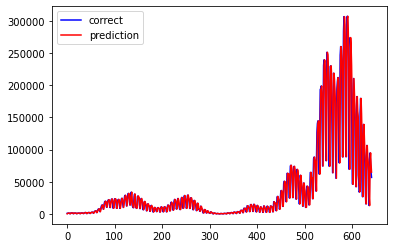

MAE: 11441.593457943925


In [42]:
def wfv(predictor, time_series, s_perc=0.2, plot=False):
    # TODO: implement walk forward validation
    m = int(s_perc * len(time_series))
    correct = time_series[m:]
    predictions = [predictor(time_series[:i]) for i in range(m, len(time_series))]
    distances = np.abs(correct - predictions)
    
    if plot:
        plt.plot(range(len(correct)), correct, color='blue', label='correct')
        plt.plot(range(len(predictions)), predictions, color='red', label='prediction')
        plt.legend()
        plt.show()
    
    return np.mean(distances)


# Evaluate naive predictor
res = wfv(naive, y_t, plot=True)
print(f'MAE: {res}')
assert np.isclose(res, 11441.593457943925)


We can see, that the simple, naive predictor gets wrong, because there is an underlying *seasonality* within the time series. In time series data, seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly. Seasonality may be caused by various factors, such as weather, vacation, and holidays and consists of periodic, repetitive, and generally regular and predictable patterns in the levels of a time series.

### Task 4 (2 Point)

Implement the `naive_season` predictor, a generalization of the `naive` predictor.
It takes an additional seasonality parameter `s` and predicts the last value of the season (e.g. if we assume a seasonality of 3 days, it would predict the value from 3 days ago).

Evaluate the `naive_season` predictor with walk forward validation and compare the result to the naive predictor. Try out different seasonality parameters from 1 (naive predictor) to 14 (bi-weekly). Which parameter gives the best result? (Print the best parameter and run wfv with plot=True for it). Did you expect the result?



best parameter: s=7


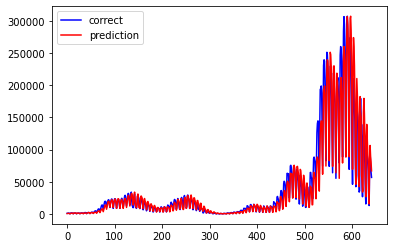

In [46]:
def naive_season(time_series, s=1):
    # TODO: implement naive + seasonality predictor
    return time_series[-s]

# TODO: evaluate naive + seasonality predictor
naive_evaluations = [wfv(lambda time_series: naive_season(time_series, s=i), y_t) for i in range(1, 14)]
best_s = np.argmin(naive_evaluations) + 1   # start at 1
print(f"best parameter: s={best_s}")
best_wfv = wfv(lambda time_series: naive_season(time_series, s=best_s), y_t, plot=True)

# Result of the wfc function for the best choice of s
assert np.isclose(best_wfv, 7685.546728971963, 0.001)

# SARIMA

SARIMA models are a widely used approach for time series prediction. The general approach is to predict the next value by explaining auto-correlations in the time series.

The name SARIMA is an acronym and stands for Seasonal AutoRegressive Integrated Moving Average.

In order to make a prediction, one has to perform five steps (which will be explained in more detail at each step):

1. Make the time series stationary (**S,I**)
2. Estimate the AutoRegressive Model using OLS (**AR**)
3. Estimate the Moving Average Model using OLS (**MA**)
4. Predict the next stationary value using 2. and 3.
5. Make prediction unstationary again

For further information, see [here](https://otexts.com/fpp2/arima.html).

## Make the time series stationary

Since we have a (general) time series, the values do strongly depend on each other and we can not use any of our classical approaches, where we assumed i.i.d. data.

However, a stationary time series is one whose properties do not depend on the time at which the series is observed. More precisely, if $y_t$ is a stationary time series, then for all $s$, the distribution of $(y_t, \dots, y_{t+s})$ does not depend on $t$.
 
Thus there is no dependence among the data due to time (e.g. periodicity, trend) and we can use classical approaches.

A simple (and reversible) way of making a time series stationary is by (seasonal) **differencing**.

For a given time series $y_1,\dots,y_n$, we create a new time series:
$$
y_t' = y_{t}-y_{t-s}\,
$$

where the integer $s$ is a seasonality parameter.

In theory, we could differenciate the differenciated time series again, to make it even more stationary.
The number of times one differenciates the time series is set by a hyperparameter $d$.
However in practice (and especially here) it is often sufficient to set $d=1$, that is to differenciate only once.
Therefore we will ignore this possibility.

### Task 5 (2 Points)

Implement the `differencing` function and test it on the corona cases dataset. Use the value for s you identified as best above and plot the result.

In [47]:
def differencing(time_series, s=1):
    # TODO: differenciate the time series
    return time_series[s:] - time_series[:-s]
    
# TODO: differenciate corona time series and plot the result

# best_s from above
y_diff = differencing(y_t, s=best_s)
assert y_diff[100] == 356.0



## Auto Regressive Model

In an auto regressive model, we assume the following model
$$
y'_t = \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right)\\
    = \begin{bmatrix}
    \theta_0\\
    \theta_1\\
    \vdots\\
    \theta_p
    \end{bmatrix}^T
    \begin{bmatrix}
    1\\
    y'_{t-1}\\
    \vdots\\
    y'_{t-p}
    \end{bmatrix}\,,
$$

where the next value of a time series is the result of an affine combination of the previous $p$ values.

Note, how the estimation of $\theta$ corresponds to the classical OLS problem.

### Task 6 (2 Points)
In order to make an Maximum Likelhood estimation, we need a dataset of samples $\left[y'_i\right]_{i=1,\dots,p}$ and labels $y'_{p+1}$.

Implement a function `time_series_dataset`, that takes a time series `time_series` and a window parameter `p` as input. The output should be a dataset of all possible sample label pairs as defined above.

In [49]:
def time_series_dataset(time_series, p):
    # TODO: create time series dataset
    return [time_series[i:i + p] for i in range(len(time_series) - p)], time_series[p:]

time_series = [0,1,2,3,4,5,6]
X, Y = time_series_dataset(time_series, 3)
assert np.allclose(X,np.array([
 [0, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5],
]))

assert np.allclose(Y,np.array([3,4,5,6]))


### Task 7 (3 Points)

Implement the auto regressive model class `AR`.

After $\theta$ was estimated from a dataset, optionally calculate the predictions
$$
\tilde{y'_t}:= \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right)
$$
and the residuals 
$$
\varepsilon_t := y'_t-\tilde{y'_t}
$$
for each sample label pair of the dataset and save the residuals as an attribute of the class.

[0 1 0 1 0 1 0]
1.0
[ 0.5 -0.5] 0.5000000000000002


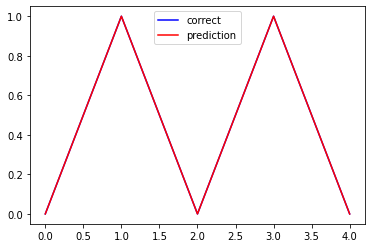

0.0

In [50]:
from sklearn.linear_model import LinearRegression
    
class AR():
    
    def __init__(self, p):
        self.p = p
        self.theta = None
        self.intercept = None
        self.residuals = None
        self.lr = LinearRegression()

    def fit(self, time_series, calc_residuals=True):
        # TODO: Generate time_series_dataset
        X, Y = time_series_dataset(time_series, self.p)
        
        # TODO: estimate theta + intercept
        self.lr.fit(X, Y)
        self.theta = self.lr.coef_
        self.intercept = self.lr.intercept_
        
        # TODO: If calc_residuals is true, predict values and calculate residuals
        if calc_residuals:
            self.residuals = Y - self.lr.predict(X)
    
    def predict(self, time_series):
        # TODO: predict next value
        return self.theta @ time_series[-self.p:] + self.intercept


time_series = np.array([0,1,0,1,0,1,0])
ar = AR(2)
ar.fit(time_series)
print(time_series[:7])
next = ar.predict(time_series[:7])
print(next)
assert np.isclose(next,1.0,0.0001)
assert np.abs(ar.residuals).sum() < 1e-14
print(ar.theta,ar.intercept)
wfv(ar.predict, time_series, s_perc=0.4, plot=True)

### Task 8 (2 Points)

Now test your `AR` class on the stationary time series from Task 5. Search for an optimal value of $p$ in the range of 1 and 10 using your walk forward validation function from above.

Since it doesn't make sense to train on the whole series and then predict data that was used in the training the function passed to wvf must first fit the AR model to the given history and then predict the next value.

For that we first define a new function `train_and_predict_ar(p)` that returns a functions that takes a history and then fit the model to that history and predicts the next value.

Using this function we can run wfv for different values of p

5


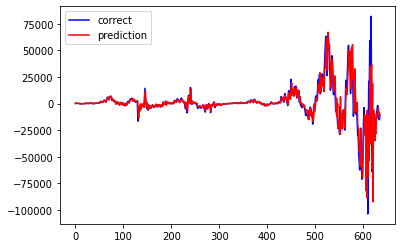

3962.6467361871737


In [53]:

def train_and_predict_ar(p):
    # TODO: INIT AR
    ar = AR(p)
    def predict(history):
        # TODO: Fit AR and predict next value
        ar.fit(history)
        return ar.predict(history)
    return predict

# TODO: Identify best value for p according to wfv in range(1,10)
wfvs = [wfv(train_and_predict_ar(p), y_diff) for p in range(1, 10)]
best_p = np.argmin(wfvs) + 1
best_wfv = np.min(wfvs)

# Best value for p
print(best_p)
assert np.isclose(best_wfv, 3962.6467361871737, 0.001)
print(wfv(train_and_predict_ar(best_p), y_diff, plot=True))

# We will need this for the next step
ar = AR(best_p)
ar.fit(y_diff)

## Moving Average Model

The Moving Average Model models the residual $\varepsilon_t$:
$$
\varepsilon_t = \phi_0+\left(\sum\limits_{i=1}^{q}\phi_i \varepsilon_{t-i} \right)\\
    = \begin{bmatrix}
    \phi_0\\
    \phi_1\\
    \vdots\\
    \phi_p
    \end{bmatrix}^T
    \begin{bmatrix}
    1\\
    \varepsilon_{t-1}\\
    \vdots\\
    \varepsilon_{t-q}
    \end{bmatrix}\,,
$$

where the next residual time series is the result of an affine combination of the previous $q$ residuals.

The estimation of $\phi$ again corresponds to the classical OLS problem. Thus, we can recycle our AR class from above and use it to build an MA class that does not calculate residuals by default.

### Task 9 (1 Point)

Use the [super](https://realpython.com/python-super/) to rename the parameter for MA to `q` and running fit without calculating residuals.


In [56]:
class MA(AR):
    def __init__(self, q):
        self.q = q
        # Call AR init, use p=q
        super().__init__(q)

    def fit(self, residual_series):
        # Call fit without calculating residuals
        super().fit(residual_series, False)

### Task 10 (1 Point)
Search for an optimal value of $q$ in the range of 1 and 7. As before we need a helper function that returns a predictor for $MA(q)$ that is fitted on the given data as well.

4 3869.870953697418


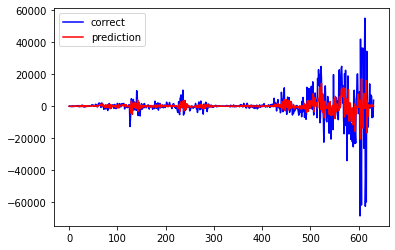

3869.870953697418


In [57]:
def train_and_predict_ma(q):
    # TODO: Init MA
    ma = MA(q)
    def predict(history):
        # TODO: Fit MA and predict next value
        ma.fit(history)
        return ma.predict(history)
    return predict

# TODO: Identify best value for q according to wfv in range(1,7)
wfvs = [wfv(train_and_predict_ma(q), ar.residuals) for q in range(1, 7)]
best_q = np.argmin(wfvs) + 1
best_wfv = np.min(wfvs)

print(best_q,best_wfv)
print(wfv(train_and_predict_ma(best_q), ar.residuals,plot=True))


The parameters $p$ and $q$ should not be optimized independently since the choice of $p$ affects the choice of $q$. We will keep that for later since we will need to do it for the final model.

## Combining AR and MA

The model underlying SARIMA is simply the combination of the auto regressive and the moving average model on seasonally differenciated data:
\begin{align}
y'_t = \theta_0+\left(\sum\limits_{i=1}^{p}\theta_i y'_{t-i} \right) + \phi_0+\left(\sum\limits_{i=1}^{q}\phi_i \varepsilon_{t-i} \right)
\end{align}
That is, the next value of our differenciated time series is a linear combination of the last $p$ values.
However, this value is disturbed with noise, which is a linear combination of the last $q$ residuals.

### Task 11 (4 Points)
Implement the `SARIMA` predictor function and perform the walk forward validation with this predictor.

Note, that the differencing has to be reverted for the predicted value. To do that you need to solve the differencing equation $y_t' = y_{t}-y_{t-s}$ for $y_t$.

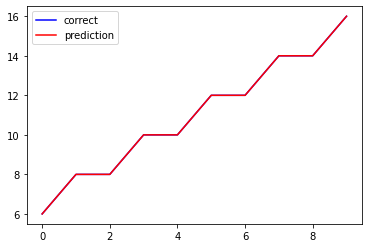

In [58]:
def SARIMA(time_series, p, q, s):
    
    # TODO: differencing
    time_series_diff = differencing(time_series, s)
    
    # TODO: auto regressive
    ar = AR(p)
    ar.fit(time_series_diff)
    ar_prediction = ar.predict(time_series_diff)
    
    # TODO: moving average
    ma = MA(q)
    ma.fit(ar.residuals)
    ma_prediction = ma.predict(ar.residuals)
    
    # TODO: combine predictions
    combined_prediction = ar_prediction + ma_prediction
    
    # TODO: revert differencing
    return combined_prediction + time_series[-s]

time_series = np.arange(16)+np.tile([0,1],8)
assert SARIMA(time_series,1,1,1) == 16
assert np.isclose(wfv(lambda x: SARIMA(x,1,1,1), time_series, s_perc=0.4, plot=True),0,0.001)

### Task 12 (2 Points)

Find the best values for $p$ and $q$ in the the range 1 to 7, $s$ should be chosen like before.

Compare the results to the baselines, did we improve? If so how much?

(1, 2) 3867.516300372142



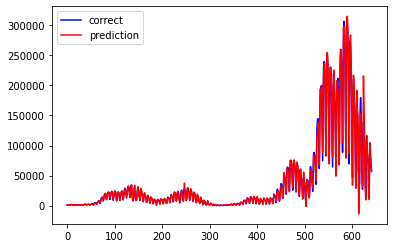

MAE: 3867.516300372142


In [69]:
# TODO: Create list of possible parameter pairs (each combination of p and q going from 1 to 7, i.e. 36 pairs)
params = [(p, q) for p in range(1, 7) for q in range(1, 7)]

# TODO: Iteratoe over list and run wfv with SARIMA()
s = best_s
wfvs = [wfv(lambda time_series: SARIMA(time_series, p, q, s), y_t) for p, q in params]
best = np.argmin(wfvs)
best_wfv = np.min(wfvs)

# Params is the list of params, best is the index of the best pair
print(params[best], best_wfv)
p = params[best][0]
q = params[best][1]
print()
print(f'MAE: {wfv(lambda x: SARIMA(x,p,q,s), y_t, plot=True)}')


### Task 13 (2 Points)

Now assume we have the 5th of May 2022. Use your best model from the previous exercises to predict the number of positive corona tests for the next 5 days, without using any data after the 5th. Instead you should append the predictions to the time series to get the next prediction. Compare your results with the actual values on those days.

[ 80280.          66988.11779345  24504.47716627   8859.52109687
  81789.04159547 102822.45417416]
794   2022-05-05 17:00:00+00:00
795   2022-05-06 17:00:00+00:00
796   2022-05-07 17:00:00+00:00
797   2022-05-08 17:00:00+00:00
798   2022-05-09 17:00:00+00:00
799   2022-05-10 17:00:00+00:00
Name: time_iso8601, dtype: datetime64[ns, UTC]


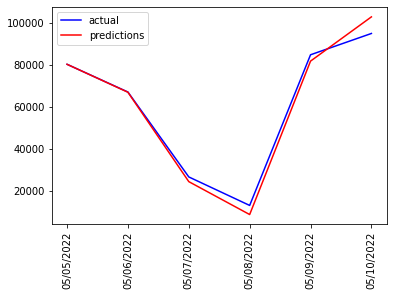

In [99]:
# TODO: Predict the case numbers for the next 5 days and print them
# i could do some fancy stuff here, or i just look it up
date_index = 793
history = y_t[:date_index + 1]
for _ in range(5):
    prediction = SARIMA(history, p, q, s)
    history = np.append(history, prediction)

# TODO: Compare them to the actual values
predictions = history[date_index:date_index + 6]
actual_values = y_t[date_index:date_index + 6]
print(predictions)
plt.plot(range(6), actual_values, color='blue', label='actual')
plt.plot(range(6), predictions, color='red', label='predictions')
dates = pd.to_datetime(df['time_iso8601'][date_index+1:date_index + 7])
xticks = [date.strftime('%m/%d/%Y') for date in dates]
print(dates)
plt.xticks(range(6), xticks, rotation='vertical')
plt.legend()
plt.show()
# looking good!